In [1]:
import os

import matplotlib.pyplot as plt
import meshio
import numpy as np
from fimpy.solver import FIMPY
from joblib import Parallel, delayed
from numba import njit, prange
from numba.typed import List
from sklearn.neighbors import BallTree
import faiss

Import of Cupy failed. The GPU version of fimpy will be unavailble. Message: No module named 'cupy'


In [2]:
try:
    import cupy as cp

    device = "gpu"
except ModuleNotFoundError:
    device = "cpu"

DTYPE = np.float32

print(f"Running on {device.upper()}.")

Running on CPU.


## Load a Mesh 
This can be any mesh format that meshio can read. However, it needs to contain linear tetrahedral elements only.

In [3]:
# File to read
mesh_name = os.path.join("control_arm", "control_arm.msh")
fill_time = 8.6
injection_locs = [[-25.000, 111.916, 18.961]]
# mesh_name = os.path.join("center_gated_disk", "center_gated_disk.msh")
# fill_time = 1.2
# injection_locs = [[0.0, 0.0, 3.0]]

# Read mesh with meshio
mesh = meshio.read(mesh_name)
points = mesh.points.astype(DTYPE)
elements = mesh.cells[0].data

## Boundary conditions 
`injection_locs` is a list of 3D coordinates on the surface of the domain and prescribes the injection gate locations. It is used to compute the Dirichlet boundary nodes for the eikonal equation that computes distances to the injection points.

In [4]:
# Get inlet nodes
inlet_nodes = []
for injection_loc in injection_locs:
    dist_to_inlet = np.linalg.norm(points - injection_loc, axis=-1)
    inlet_nodes.append(np.argmin(dist_to_inlet, axis=0))
inlet_nodes = np.array(inlet_nodes)

In addition to the injection nodes, all surface nodes are determined to compute distances to the next mold wall.

In [5]:
# Get surface nodes
faces = np.vstack(
    [
        elements[:, [0, 1, 2]],
        elements[:, [1, 2, 3]],
        elements[:, [0, 2, 3]],
        elements[:, [0, 1, 3]],
    ]
)
faces = np.sort(faces, axis=1)
_, indices, counts = np.unique(faces, axis=0, return_counts=True, return_index=True)
indices = indices[np.argwhere(counts == 1)]
surface_nodes = np.unique(faces[indices]).ravel()

## Compute the distance measures

In [6]:
fim = FIMPY.create_fim_solver(points, elements, device=device)

The first distance is the geodesic distance to the nearest mold wall $D_w$. 

In [7]:
# Set velocity field isotropic to 1
f = np.stack([np.eye(3)] * len(elements))

# Compute geodesic distance to walls
D_w = fim.comp_fim(surface_nodes, np.zeros_like(surface_nodes), f)
mesh.point_data["D_w"] = D_w

The next distance is the geodesic distance to the nearest inlet location $D_i$. 

In [8]:
# Compute geodesic distance to inlet
D_i = fim.comp_fim(inlet_nodes, np.zeros_like(inlet_nodes), f)
mesh.point_data["D_i"] = D_i

The next distance is the weightes distance to the nearest inlet location $\hat{D}_i$. 

In [9]:
# Set velocity field isotropic to wall distance
D_w_elements = np.mean(D_w[elements], axis=1)
f = np.einsum("i,jk->ijk", D_w_elements, np.eye(3))

# Compute weighted distance to inlet
D_i_hat = fim.comp_fim(inlet_nodes, np.zeros_like(inlet_nodes), f)
mesh.point_data["D_i_hat"] = D_i_hat

## Nodal volumes
The volume attributed to each node is computed for further processing. Therefore, a fourth of each cells volume is contributing to the volume associated with each of its nodes.

In [10]:
cell_coords = points[elements]
centers = np.mean(cell_coords, axis=1)

# Get node to cell relations
n2e = {k: [] for k in range(len(points))}
for i, cell in enumerate(elements):
    for j, node in enumerate(cell):
        n2e[node].append(i)

# Get cell volumes
a = cell_coords[:, 1, :] - cell_coords[:, 0, :]
b = cell_coords[:, 2, :] - cell_coords[:, 0, :]
c = cell_coords[:, 3, :] - cell_coords[:, 0, :]
omega = np.einsum("ij,ij->i", a, np.cross(b, c), optimize=True)
cell_volumes = np.abs(omega) / 6.0

# Interpolate volume field to points
node_volumes = np.array(
    [np.sum(cell_volumes[n2e[node]] / 4.0) for node in range(len(points))]
)
mesh.point_data["Volume"] = node_volumes

## Normalization
The weighted distance to the injection gate and nodal volumes are used to construct a normalized fill front in which equal increments of the fill front imply equal increemnts in filled volume. Then, the gradient of the new fill front approximation is computed with a tetragonal shape function and interpolated to nodes. 

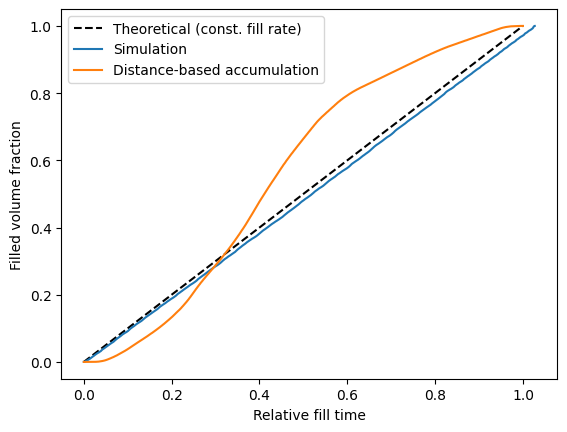

In [11]:
if device == "gpu":
    dist = D_i_hat.get().ravel()
else:
    dist = D_i_hat.ravel()
time = mesh.point_data["Fill_time"].ravel()
volume = mesh.point_data["Volume"].ravel()

distorder = np.argsort(dist)
timeorder = np.argsort(time)
distF = np.cumsum(volume[distorder])
timeF = np.cumsum(volume[timeorder])
plt.plot([0, 1], [0, 1], "--k")
plt.plot((time[timeorder] / fill_time), (timeF / np.sum(volume)))
plt.plot((dist[distorder] / np.max(dist)), (distF / np.sum(volume)))
plt.xlabel("Relative fill time")
plt.ylabel("Filled volume fraction")
plt.legend(
    ["Theoretical (const. fill rate)", "Simulation", "Distance-based accumulation"]
)
plt.show()

In [12]:
order = np.argsort(dist)
ridx = np.argsort(order)
F = np.cumsum(node_volumes[order]) / np.sum(node_volumes)
fill_front_norm = F[ridx]
mesh.point_data["Normalized_fill_front"] = fill_front_norm

In [13]:
# Compute gradient
B = np.array([[-1.0, 1.0, 0.0, 0.0], [-1.0, 0.0, 1.0, 0.0], [-1.0, 0.0, 0.0, 1.0]])
J = B @ points[elements, :]
edirs = np.einsum("...ij, ...j", np.linalg.inv(J) @ B, fill_front_norm[elements])
ndirs = np.array([np.mean(edirs[n2e[node]], axis=0) for node in range(len(points))])
mesh.point_data["Fill_gradient"] = ndirs / np.linalg.norm(ndirs, axis=1)[:, None]

## Structure tensor
The structure tensor is a second order tensor measuring the directionality of the material distribution in the domain.

In [55]:
@njit(fastmath=True)
def compute_structure_tensor(points, centers, volumes, lims, dist, indices):
    num_points = len(points)
    result = np.zeros((num_points, 3, 3), dtype=DTYPE)
    for i in prange(num_points):
        idx = indices[lims[i]:lims[i+1]]
        diffs = centers[idx] - points[i]
        vols = volumes[idx]
        dirs = diffs.T / dist[lims[i]:lims[i+1]]
        result[i, :, :] = np.dot(vols * dirs, dirs.T) / np.sum(vols)
    return result


def tensor_sweep(points, centers, volumes, radius):
    quantizer = faiss.IndexFlatL2(3) 
    index = faiss.IndexIVFFlat(quantizer, 3, 100)
    index.nprobe = 30
    index.train(centers)
    index.add(centers)

    def process_chunk(chunk):
        lims, D, I = index.range_search(chunk, int(radius**2))
        return compute_structure_tensor(chunk, centers, volumes, lims, np.sqrt(D), I)

    chunks = np.array_split(points, 10000)
    results = [process_chunk(chunk) for chunk in chunks]
    return np.concatenate(results)

In [36]:
def gpu_compute_structure_tensor(points, centers, volumes, lims, dist, indices):
    num_points = len(points)
    points = cp.asarray(points)
    centers = cp.asarray(centers)
    volumes = cp.asarray(volumes)
    dist = [cp.asarray(d, dtype=DTYPE) for d in dist]
    result = cp.zeros((num_points, 3, 3), dtype=DTYPE)
    for i in range(num_points):
        idx = indices[lims[i]:lims[i+1]]
        diffs = centers[idx] - points[i]
        vols = volumes[idx]
        dirs = diffs.T / dist[lims[i]:lims[i+1]]
        result[i] = cp.dot(vols * dirs, dirs.T) / cp.sum(vols)
    return result


def gpu_tensor_sweep(points, centers, volumes, radius):
    quantizer = faiss.IndexFlatL2(3) 
    index = faiss.IndexIVFFlat(quantizer, 3, 100)
    index.nprobe = 30
    index.train(centers)
    index.add(centers)

    def process_chunk(chunk):
        lims, D, I = index.range_search(chunk, int(radius**2))
        return gpu_compute_structure_tensor(chunk, centers, volumes, lims, np.sqrt(D), I)

    chunks = np.array_split(points, 10000)
    results = [process_chunk(chunk) for chunk in chunks]
    return cp.concatenate(results)

In [56]:
# Compute structure tensor
bounding_box = np.max(points, axis=0) - np.min(points, axis=0)
radius = min(0.25 * np.max(bounding_box), np.min(bounding_box))
if device == "gpu":
    tensors = gpu_tensor_sweep(points, centers, cell_volumes, radius)
else:
    tensors = tensor_sweep(points, centers, cell_volumes, radius)
mesh.point_data["Structure_tensor"] = tensors.reshape((-1, 9))[:, [0, 4, 8, 1, 5, 2]]

## Export results

In [57]:
if "gmsh:geometrical" in mesh.cell_data.keys():
    mesh.cell_data.pop("gmsh:geometrical")
if "gmsh:dim_tags" in mesh.point_data.keys():
    mesh.point_data.pop("gmsh:dim_tags")
meshio.write("control_arm_hole.vtu", mesh)